# Model evaluation

In [44]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from torch.utils.data import DataLoader
from pathlib import Path
from itertools import chain

# update the path so we can directly import code from the DVlog
sys.path.append(os.path.dirname(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'DVlog'))))

from DVlog.utils.dataloaders import BaseDVlogDataset
from DVlog.utils.metrics import calculate_performance_measures, calculate_fairness_measures
from DVlog.models.model import BimodalDVlogModel, UnimodalDVlogModel

In [30]:
# HARDCODE SOME VARIABLES
# batch size: 32
# epochs: 50
# learning rate: 0.0002
# sequence length (t): 596
BATCH_SIZE = 32
SEQUENCE_LENGTH = 596
DIM_MODEL = 256
N_HEADS_UNIMODAL = 8
N_HEADS_CROSS = 8
USE_GPU = True
USE_STD = False
SAVED_MODEL_WEIGHTS = "bimodal_dvlog_v2_cross16"
SAVED_MODEL_PATH = Path(f"../DVlog/trained_models/model_{SAVED_MODEL_WEIGHTS}")

# evaluation parameters
modality = "both" # can choose between 'acoustic', 'visual', or 'both'
dataset = "test" # can choose between 'test', 'train', or 'val'
fairness_unprivileged = "m"
visual_feature_dim = 136
acoustic_feature_dim = 25

# do the checks over the parameters
assert modality in ["visual", "acoustic", "both"], f"Modality type not in choices: {modality}"
assert dataset in ["test", "train", "val"], f"Chosen dataset not in choices: {dataset}"
assert SAVED_MODEL_PATH.is_file(), f"Saved model not found: {SAVED_MODEL_PATH}"


# setup the paths
annotations_file = Path(r"../DVlog/dataset/dvlog_labels_v2.csv")
data_dir = Path(r"../DVlog/dataset/dvlog-dataset")

In [33]:
# load the saved version of the model
if modality == "acoustic":
    # acoustic unimodel
    saved_model = UnimodalDVlogModel(data_shape=(SEQUENCE_LENGTH, acoustic_feature_dim), d_model=DIM_MODEL, n_heads=N_HEADS_UNIMODAL, use_std=USE_STD)
elif modality == "visual":
    # visual unimodel
    saved_model = UnimodalDVlogModel(data_shape=(SEQUENCE_LENGTH, visual_feature_dim), d_model=DIM_MODEL, n_heads=N_HEADS_UNIMODAL, use_std=USE_STD)
else:
    # bimodal model
    saved_model = BimodalDVlogModel(d_model=DIM_MODEL, n_heads=N_HEADS_CROSS, use_std=USE_STD)

saved_model.load_state_dict(torch.load(SAVED_MODEL_PATH))
# Set the model to evaluation mode
saved_model.eval()

# load in the dataset
eval_dataset = BaseDVlogDataset(annotations_file, data_dir, dataset=dataset, sequence_length=SEQUENCE_LENGTH, to_tensor=True, with_protected=True)

# setup the dataloader
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)

predictions = []
y_labels = []
protected = []

# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    for i, vdata in enumerate(eval_dataloader):

        # choose the appropriate inputs
        if modality == "acoustic":
            _, v_inputs, vlabels, v_protected = vdata
        elif modality == "visual":
            v_inputs, _, vlabels, v_protected = vdata
        else:
            v_inputs_v, v_inputs_a, vlabels, v_protected = vdata

        # forward + backward + optimize
        if modality == "both":
            voutputs = saved_model((v_inputs_a, v_inputs_v))
        else:
            voutputs = saved_model(v_inputs)

        # save the predictions and ground truths from each batch for processing
        predictions.append(voutputs.numpy())
        y_labels.append(vlabels.numpy())
        protected.append(v_protected)

# get the performance and fairness metrics
accuracy, precision, recall, fscore = calculate_performance_measures(y_labels, predictions)
eq_odds, eq_oppor, eq_acc = calculate_fairness_measures(y_labels, predictions, protected, fairness_unprivileged)

# print out all the metrics
print(f"Model: {SAVED_MODEL_WEIGHTS}\n----------")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {fscore}\n----------")
print(f"Equal odds: {eq_odds}\nEqual opportunity: {eq_oppor}\nEqual accuracy: {eq_oppor}\n----------")

Model: bimodal_dvlog_v2_cross16
----------
Accuracy: 0.5393939393939394
Precision: 0.2909458218549128
Recall: 0.5393939393939394
F1-score: 0.37800047721307567
----------
Equal odds: 1.0
Equal opportunity: 1.0
Equal accuracy: 1.0
----------


C:\Users\stan_\anaconda3\envs\dvlog_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# first flatten the predictions and ground truths
y_pred = np.argmax(np.concatenate(predictions), axis=1)
y_true = np.argmax(np.concatenate(y_labels), axis=1)
y_protected = np.array(list(chain.from_iterable(protected)))

# check the precision, recall, F1-score for each gender
m_indices = np.where(y_protected == 'm')
y_pred_m = y_pred[m_indices]
y_true_m = y_true[m_indices]

f_indices = np.where(y_protected == 'f')
y_pred_f = y_pred[f_indices]
y_true_f = y_true[f_indices]

# print it
f_prec, f_rec, f_f1, _ = precision_recall_fscore_support(y_true_f, y_pred_f, average="weighted", zero_division=0)
print(f"Female metrics:\n---\nPrecision: {f_prec}\nRecall: {f_rec}\nF1-score: {f_f1}\n----------")

m_prec, m_rec, m_f1, _ = precision_recall_fscore_support(y_true_m, y_pred_m, average="weighted", zero_division=0)
print(f"Male metrics:\n---\nPrecision: {m_prec}\nRecall: {m_rec}\nF1-score: {m_f1}\n----------")

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Female metrics:
---
Precision: 0.308641975308642
Recall: 0.5555555555555556
F1-score: 0.39682539682539686
----------
Male metrics:
---
Precision: 0.25884887657740846
Recall: 0.5087719298245614
F1-score: 0.34312525499796004
----------


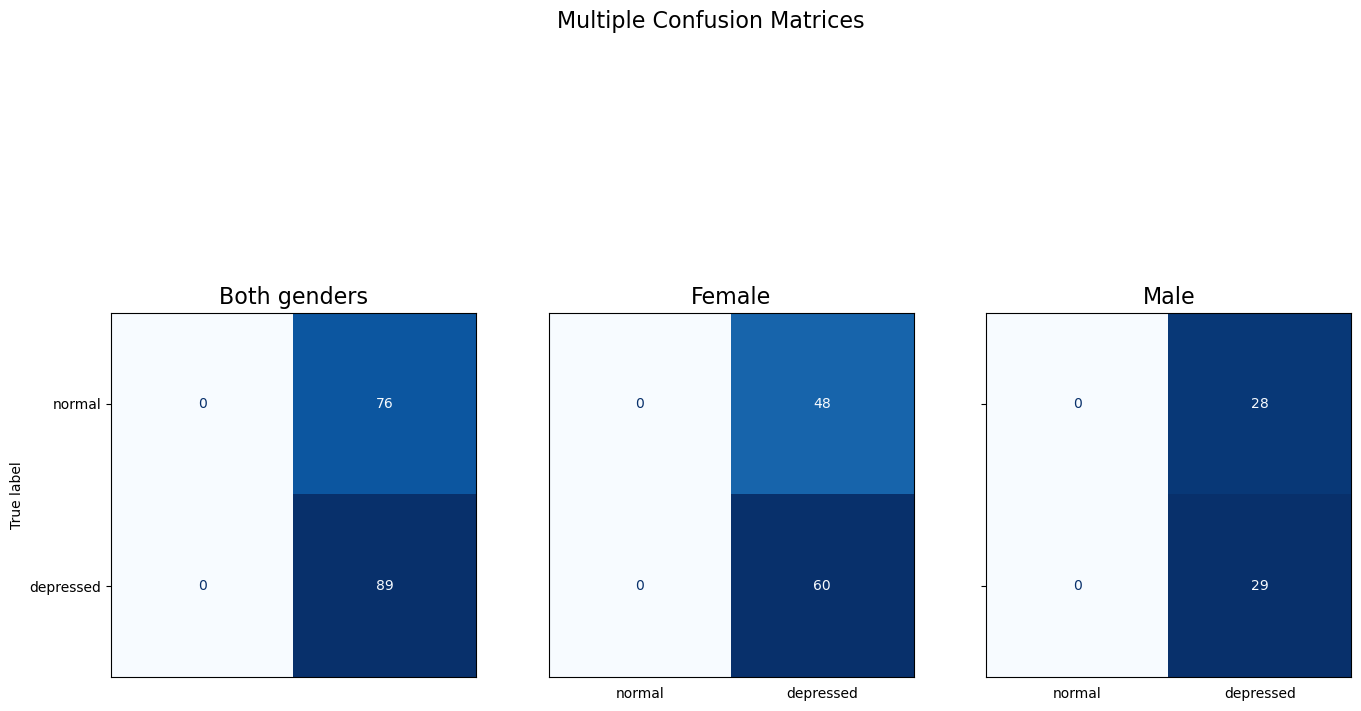

In [79]:
# make a confusion matrix for the predictions
title_size = 16
cmap = "Blues"  # Try "Greens". Change the color of the confusion matrix.
colorbar = False
labels = [0, 1]
display_labels = ["normal", "depressed"]

cm_both = confusion_matrix(y_true, y_pred, labels=labels)
cm_m = confusion_matrix(y_true_m, y_pred_m, labels=labels)
cm_f = confusion_matrix(y_true_f, y_pred_f, labels=labels)

# Create subplots for given confusion matrices
f, axes = plt.subplots(1, 3, figsize=(16, 10))

# Plot the first confusion matrix (Model 1) at position (0, 0)
axes[0].set_title("Both genders", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=cm_both, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0], colorbar=colorbar)

# Remove x-axis labels and ticks
# axes[0].xaxis.set_ticklabels(['', ''])
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot the second confusion matrix (Model 2) at position (0, 1)
axes[1].set_title("Female", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=cm_f, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1], colorbar=colorbar)

# Remove x and y-axis labels and ticks
# axes[1].xaxis.set_ticklabels(['', ''])
axes[1].yaxis.set_ticklabels(['', ''])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='both', which='both', bottom=False, left=False)

# Plot the third confusion matrix (Model 3) at position (1, 0)
axes[2].set_title("Male", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=cm_m, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[2], colorbar=colorbar)

# Remove x-axis labels and ticks
# axes[2].xaxis.set_ticklabels(['', ''])
axes[2].yaxis.set_ticklabels(['', ''])
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].tick_params(axis='x', which='both', bottom=False)

# Set the figure's suptitle and display the plot
f.suptitle("Multiple Confusion Matrices", size=title_size, y=0.93)

plt.show()